In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
today = datetime.today().strftime('%Y%m%d')

In [2]:
training_logs_dir = 'evaluation_logs'
watch_dates = ['20200106']#['20191118', '20191218']
contents = [] 
for watch_date in watch_dates:
    contents.append(pd.read_csv('{}.txt'.format(os.path.join(training_logs_dir, watch_date)), sep='\t'))
logs_df = pd.concat(contents, axis=0).reset_index()
logs_df.head()

,index,epoch,seed,train,strategy,accuracy,loss
0,0,1,10,True,freeze,46.922,0.022765
1,1,1,10,False,freeze,59.350,0.018236
2,2,1,10,True,shuffle,46.506,0.022913
3,3,1,10,False,shuffle,59.420,0.019538
4,4,1,10,True,homogeneous,78.800,0.021347


In [3]:
style_args = {
    'linestyle' : {
        'train': '-',
        'test': '--'
    },
    'colors': {
        'freeze': '#B61616',
        'shuffle': '#5AB616',
        'homogeneous': '#26A4C1',
        'heterogeneous': '#3626C1',
        'max_k_loss': '#ECAA1D',
        'min_k_loss': '#EC2CDB'
    }
}

---

In [4]:
def summarize(df, is_train, strategy, get_acc=True):
    '''
    @df = dataframe with the training/testing logs (epoch, seed, train, shuffle, accuracy, loss)
    @is_train = boolean whether to look at training logs
    @is_shuffle = boolean whether the data is shuffled
    @get_acc = boolean whether to get the accuracy or the loss
    '''
    subset_df = df[['epoch', 'accuracy', 'loss']].loc[(logs_df['train'] == is_train) & (logs_df['strategy'] == strategy)]
    grouped_df = subset_df.groupby('epoch')
    if get_acc:
        return {'mean': grouped_df.mean().values.T[0], 'std': grouped_df.std().values.T[0]}
    else:
        return {'mean': grouped_df.mean().values.T[1], 'std': grouped_df.std().values.T[1]}

In [5]:
def metric_over_epochs(strategies, get_acc=True, data_dir='figures'):
    best_vals = {}
    for is_train in [True, False]:
        plt.close()
        plt.figure(figsize=(12,12))
        for strategy in strategies:
            # data
            metric_dict = summarize(logs_df, is_train, strategy, get_acc=get_acc)
            
            means = metric_dict['mean']
            stds = metric_dict['std']
            upper_shadow = means + stds
            lower_shadow = means - stds
            idxs = range(len(means))
            
            # graph settings
            train_mode = 'train' if is_train else 'test'
            name = '{}/{}'.format(train_mode, strategy)
            best_vals[name] = max(means)
            color = style_args['colors'][strategy]
            linestyle = style_args['linestyle'][train_mode]

            # plotting
            plt.plot(idxs, means, label=name, color=color, linestyle=linestyle)
            plt.fill_between(idxs, means, upper_shadow, color=color, linestyle=linestyle, alpha=0.5)
            plt.fill_between(idxs, lower_shadow, means, color=color, linestyle=linestyle, alpha=0.5)

        plt.title('Change of {} over iterations'.format('accuracy' if get_acc else 'loss'))
        plt.xlabel('Iteration')
        plt.ylabel('{}'.format('Accuracy' if get_acc else 'Loss'))
        plt.legend();
        plt.plot()
        plt.savefig('{}/{}_{}_{}.jpg'.format(data_dir, today, 
                                             'accuracy' if get_acc else 'loss', 
                                             'train' if is_train else 'test'), format='jpg')
        
    print("Best values:")
    print(pd.Series(best_vals))

In [6]:
strategies = list(style_args['colors'].keys())
strategies

['freeze',
 'shuffle',
 'homogeneous',
 'heterogeneous',
 'max_k_loss',
 'min_k_loss']

Best values:
train/freeze            47.060000
train/shuffle           46.765333
train/homogeneous       79.843333
train/heterogeneous     51.617333
train/max_k_loss         0.000000
train/min_k_loss       100.000000
test/freeze             57.326667
test/shuffle            58.903333
test/homogeneous        10.000000
test/heterogeneous      60.586667
test/max_k_loss          9.996667
test/min_k_loss         10.000000
dtype: float64


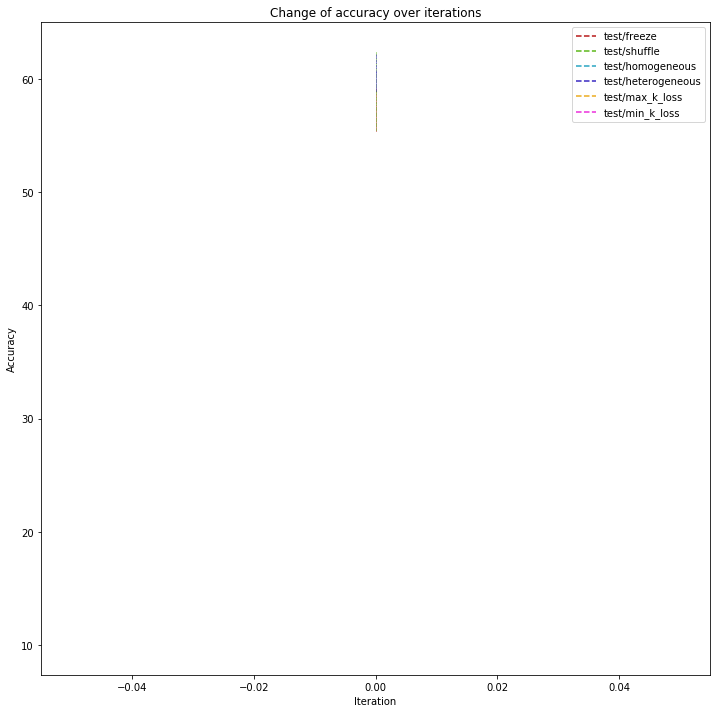

In [7]:
metric_over_epochs(strategies, get_acc=True)

Best values:
train/freeze           0.022752
train/shuffle          0.022841
train/homogeneous      0.019601
train/heterogeneous    0.020852
train/max_k_loss       0.048144
train/min_k_loss       0.023851
test/freeze            0.018988
test/shuffle           0.019198
test/homogeneous       0.063451
test/heterogeneous     0.018246
test/max_k_loss        0.038849
test/min_k_loss        0.065781
dtype: float64


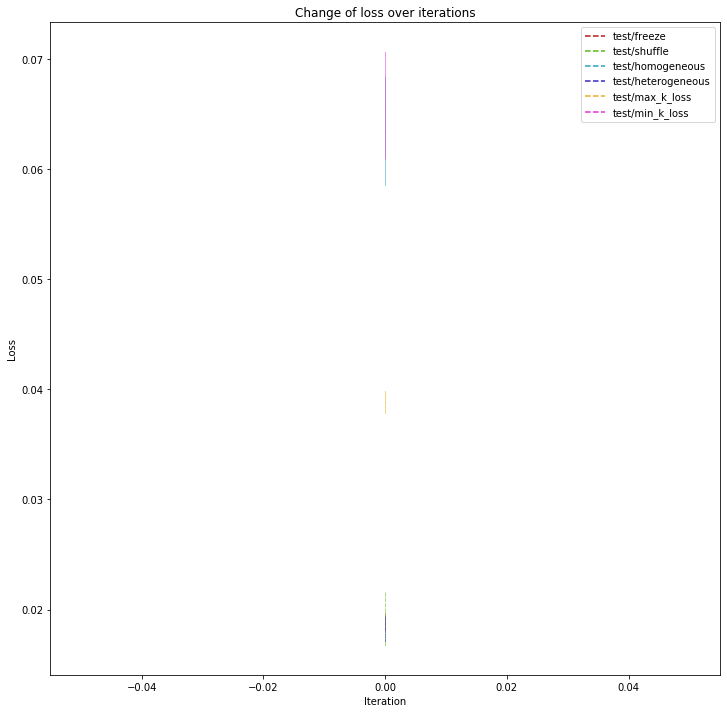

In [8]:
metric_over_epochs(strategies, get_acc=False)